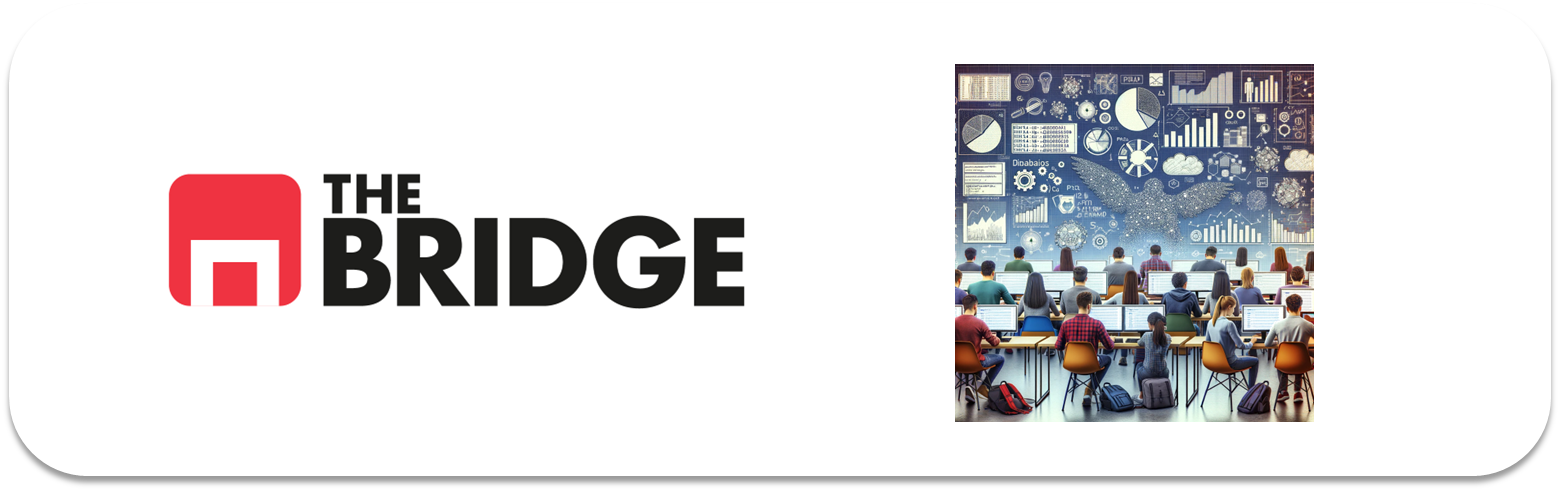

## Titanic **Clasificacion y Regresion Logistica**

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [1]:
import bootcampviztools as bt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


### Indicaciones

A continuación tienes las indicaciones para hacer el modelado.

En concreto se pide hacer un modelo de regresión logística, evaluarlo contra un dataset de test reservado del original mostrando las métricas propias de los problemas de clasificación, la matriz de confusión y la curva ROC. Además se pide comparar las predicciones con los valores reales y al final adaptar el modelo a un problema multiclase.

Los pasos para guiar el trabajo:
1. Carga el dataset del Titanic. 
2. Deshazte de las variables que no vayas a usar. Limpia lo que creas necesarios pero no hagas imputaciones.
3. Escoge y analiza la variable target de forma gráfica y razona sobre el impacto de la distribución en los resultados esperados. Ten en cuenta que lo que queremos es poder predecir si un pasajero sobrevivirá.
4. Haz el split en train y test que creas conveniente pero asegurándote que ambos conjuntos tienen un reparto similar de pasajeros embarcados en las tres ciudades.
5. Construye las parejas X,y de train y test.
6. Ahora sí imputa los nulos con medias y modas en la X de train. Guarda esas medias que necesitarás en la parte de test.
7. Haz un mini-EDA, selecciona las features que quieres quedarte y por qué.
8. Trata las variables para que funcionen lo mejor posible en el modelo.
9. Construye un modelo de regresión logística.
10. EXTRA: Analiza si lo crees conveniente los pesos y la importancia de las features.
11. Procesa el dataset de Test para que puedas usarlo en la evaluación 
12. Evalúa tu modelo contra el dataset de test y train. Obten las matrices de confusión y las métricas que creas adecuadas. Haz un pequeño assesment de su generabilidad.
13. EXTRA: Halla la probabilidad de supervivencia de un hombre de entre 30 y 40 años, que embarcó en Southampton, viajaba solo y no pagó el billete. Para ello recuerda que la probabilidad del suceso unión de sucesos indepentientes es la suma de las probabilidades de los sucesos por separado (PISTA: Aplicalo a la edad)
14. EXTRA: Aprovecha todo el trabajo haciendo un único cambio en el target, ahora será la clase del viajero. Cambia el target quitándolo de X_train, X_test y añade a estos el target anterior. El resto no deberías cambiarlo. Entrena y evalua el modelo sólo con el classification_report.  



In [2]:
df = pd.read_csv("./data/titanic.csv")

In [3]:
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   survived     891 non-null    int64  
 1   pclass       891 non-null    int64  
 2   sex          891 non-null    object 
 3   age          714 non-null    float64
 4   sibsp        891 non-null    int64  
 5   parch        891 non-null    int64  
 6   fare         891 non-null    float64
 7   embarked     889 non-null    object 
 8   class        891 non-null    object 
 9   who          891 non-null    object 
 10  adult_male   891 non-null    bool   
 11  deck         203 non-null    object 
 12  embark_town  889 non-null    object 
 13  alive        891 non-null    object 
 14  alone        891 non-null    bool   
dtypes: bool(2), float64(2), int64(4), object(7)
memory usage: 92.4+ KB


In [5]:
target = "survived"

In [6]:
excluidas = ["embark_town","alive","class", "adult_male"] # son datos repetidos (o combinaciones lineales) en otras columnas

### Limpieza y primera seleccion (las no convertidas)

In [7]:
df_deck = df.copy()
df_deck["deck"] = df_deck.deck.fillna("UNK")

In [8]:
#excluidas = ["alive","embark_town","class"]
features_base = [col for col in df_deck.columns if col not in excluidas ]
features_base.remove("deck") #sin deck, la quitamos por tener muchos nulos
features_base_deck = [col for col in df_deck.columns if col not in excluidas] # con deck tratada con UNK


### Train and test split

Quiero estratificar respecto a la ciudad de embarque pero tiene nulos. Dos opciones:
1. Me cargo las filas.
2. Son dos, me olvido de los consejos de clase e imputo por la moda 

In [9]:
df_deck.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   survived     891 non-null    int64  
 1   pclass       891 non-null    int64  
 2   sex          891 non-null    object 
 3   age          714 non-null    float64
 4   sibsp        891 non-null    int64  
 5   parch        891 non-null    int64  
 6   fare         891 non-null    float64
 7   embarked     889 non-null    object 
 8   class        891 non-null    object 
 9   who          891 non-null    object 
 10  adult_male   891 non-null    bool   
 11  deck         891 non-null    object 
 12  embark_town  889 non-null    object 
 13  alive        891 non-null    object 
 14  alone        891 non-null    bool   
dtypes: bool(2), float64(2), int64(4), object(7)
memory usage: 92.4+ KB


In [10]:
#df_deck = df_deck.loc[df_deck.embarked.isna() == False].copy()
df_deck.loc[df_deck["embarked"].isna(), "embarked"] = "S"  # la moda aunque no sea lo más correcto por contaminación...

In [11]:
train_set, test_set = train_test_split(df_deck, test_size= 0.2, stratify= df_deck["embarked"], random_state= 42)

In [12]:
train_set.embarked.value_counts(normalize= True)

embarked
S    0.724719
C    0.188202
Q    0.087079
Name: proportion, dtype: float64

In [13]:
test_set.embarked.value_counts(normalize= True)

embarked
S    0.726257
C    0.189944
Q    0.083799
Name: proportion, dtype: float64

In [14]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 838 to 571
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   survived     712 non-null    int64  
 1   pclass       712 non-null    int64  
 2   sex          712 non-null    object 
 3   age          561 non-null    float64
 4   sibsp        712 non-null    int64  
 5   parch        712 non-null    int64  
 6   fare         712 non-null    float64
 7   embarked     712 non-null    object 
 8   class        712 non-null    object 
 9   who          712 non-null    object 
 10  adult_male   712 non-null    bool   
 11  deck         712 non-null    object 
 12  embark_town  712 non-null    object 
 13  alive        712 non-null    object 
 14  alone        712 non-null    bool   
dtypes: bool(2), float64(2), int64(4), object(7)
memory usage: 79.3+ KB


### Imputamos

In [15]:
es_hombre = train_set.who == "man"
es_mujer = train_set.who == "woman"
es_child = train_set.who == "child"

mean_man = train_set[es_hombre]["age"].mean()
mean_woman = train_set[es_mujer]["age"].mean()
mean_child = train_set[es_child]["age"].mean()
es_nulo = train_set.age.isna()
es_nulo_test = test_set.age.isna()

train_set.loc[es_hombre & es_nulo, "age"] = mean_man
train_set.loc[es_mujer & es_nulo, "age"] = mean_woman
train_set.loc[es_child & es_nulo, "age"] = mean_child

test_set.loc[(test_set.who == "man") & es_nulo_test, "age"] = mean_man
test_set.loc[(test_set.who == "woman") & es_nulo_test, "age"] = mean_woman
test_set.loc[(test_set.who == "child") & es_nulo_test, "age"] = mean_child

In [16]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 179 entries, 395 to 9
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   survived     179 non-null    int64  
 1   pclass       179 non-null    int64  
 2   sex          179 non-null    object 
 3   age          179 non-null    float64
 4   sibsp        179 non-null    int64  
 5   parch        179 non-null    int64  
 6   fare         179 non-null    float64
 7   embarked     179 non-null    object 
 8   class        179 non-null    object 
 9   who          179 non-null    object 
 10  adult_male   179 non-null    bool   
 11  deck         179 non-null    object 
 12  embark_town  177 non-null    object 
 13  alive        179 non-null    object 
 14  alone        179 non-null    bool   
dtypes: bool(2), float64(2), int64(4), object(7)
memory usage: 19.9+ KB


In [17]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 838 to 571
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   survived     712 non-null    int64  
 1   pclass       712 non-null    int64  
 2   sex          712 non-null    object 
 3   age          712 non-null    float64
 4   sibsp        712 non-null    int64  
 5   parch        712 non-null    int64  
 6   fare         712 non-null    float64
 7   embarked     712 non-null    object 
 8   class        712 non-null    object 
 9   who          712 non-null    object 
 10  adult_male   712 non-null    bool   
 11  deck         712 non-null    object 
 12  embark_town  712 non-null    object 
 13  alive        712 non-null    object 
 14  alone        712 non-null    bool   
dtypes: bool(2), float64(2), int64(4), object(7)
memory usage: 79.3+ KB


### Mini-EDA

In [18]:
train_set[target].value_counts(normalize = True)

survived
0    0.626404
1    0.373596
Name: proportion, dtype: float64

Ligeramente desequilibrado, que no muchísimo, habría que estudiar cómo equilibrarlo en caso de que los resultados no sean los adecuados para la clase que se quiera predecir con mayor prioridad.

Usaremos el pairplot para verlo mejor gracias al hue, pero en dos tandas y las categóricas ya pasadas a números (pclass, alone, adult_male) las veremos con su tabla de contigencia y el análisis visual

In [19]:
features_base

['survived',
 'pclass',
 'sex',
 'age',
 'sibsp',
 'parch',
 'fare',
 'embarked',
 'who',
 'alone']

In [20]:
features_num = ["age","sibsp","parch","fare"]

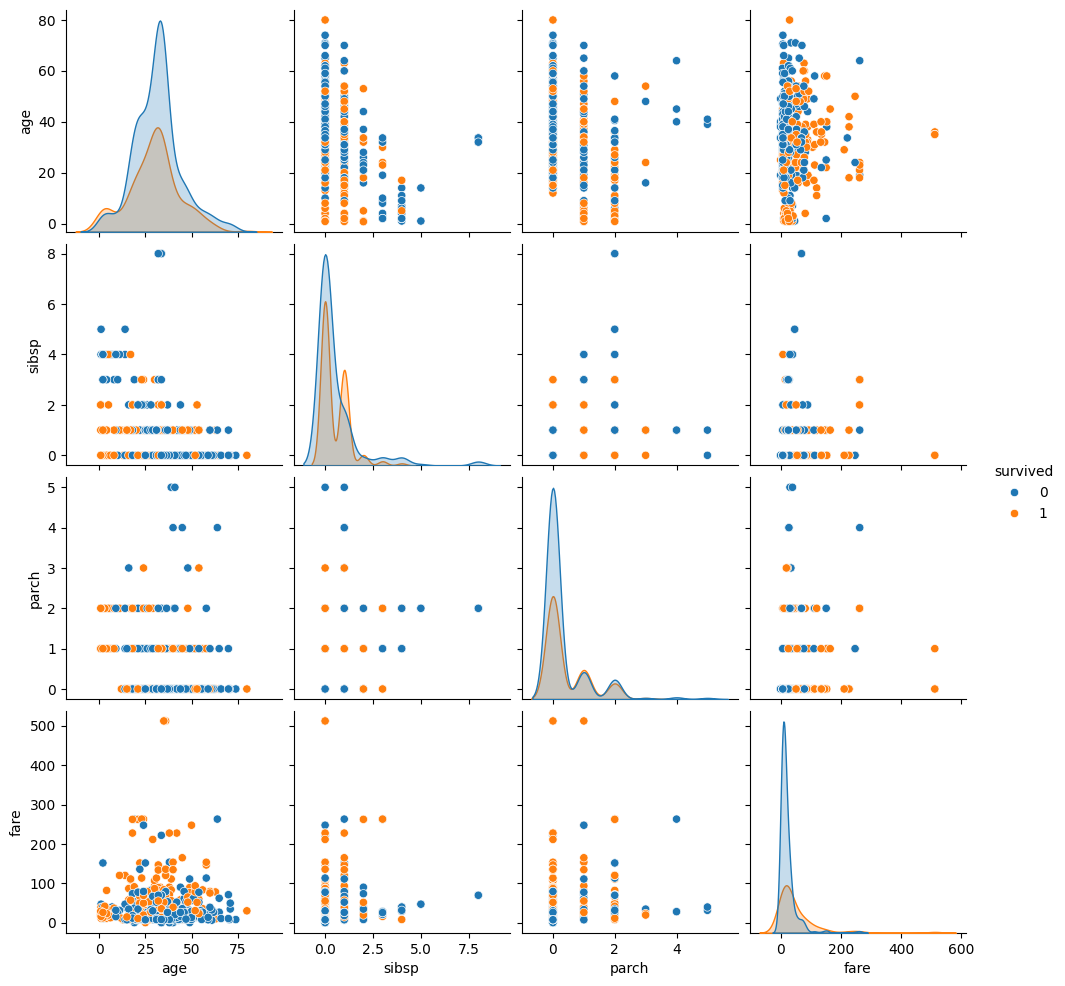

In [21]:
sns.pairplot(train_set[features_num + [target]], hue = target)

In [22]:
features_num = ["fare","age","sibsp"] # no cogemos parch porque mirando su densidad de probabilidad condicionada a sobrevivir, las curvas no se diferencian bien

In [23]:
features_cat = ["pclass","sex","embarked","alone","who","deck"]

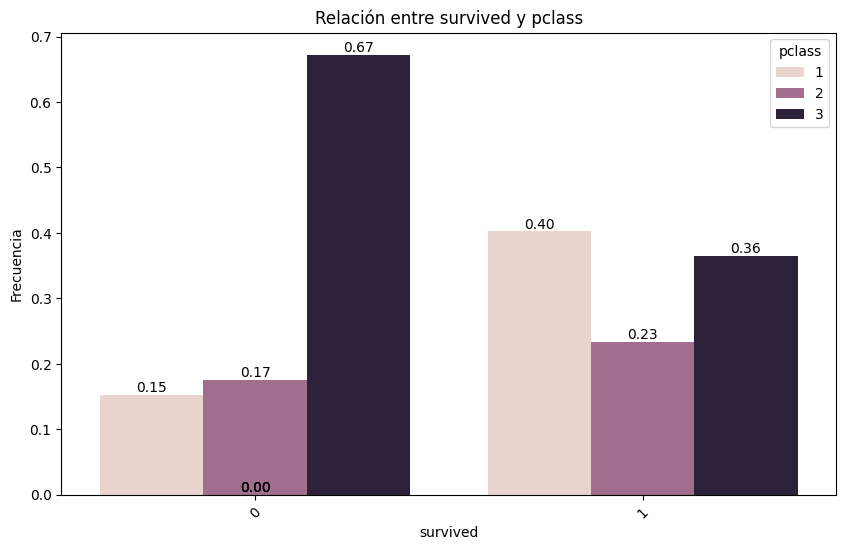

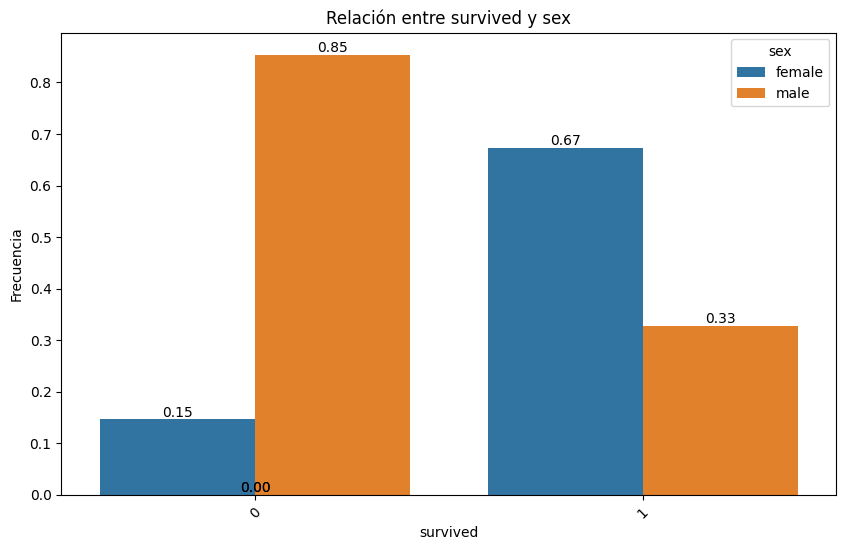

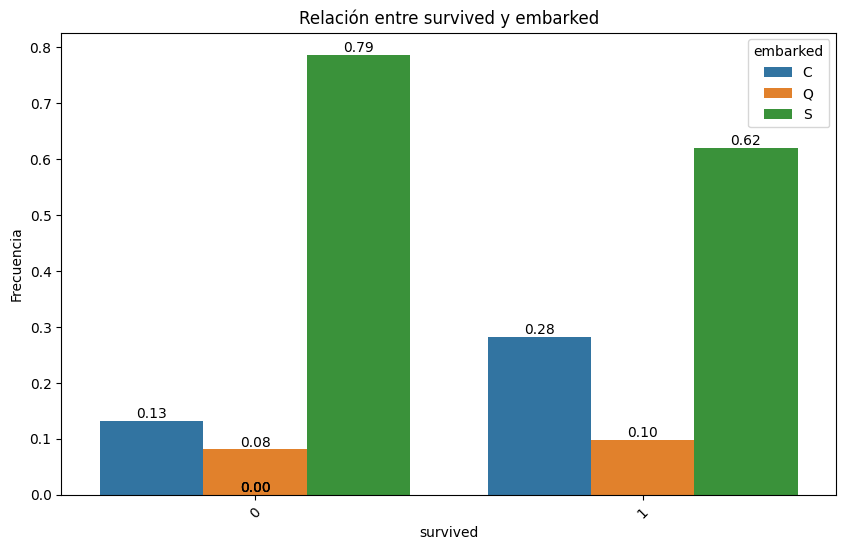

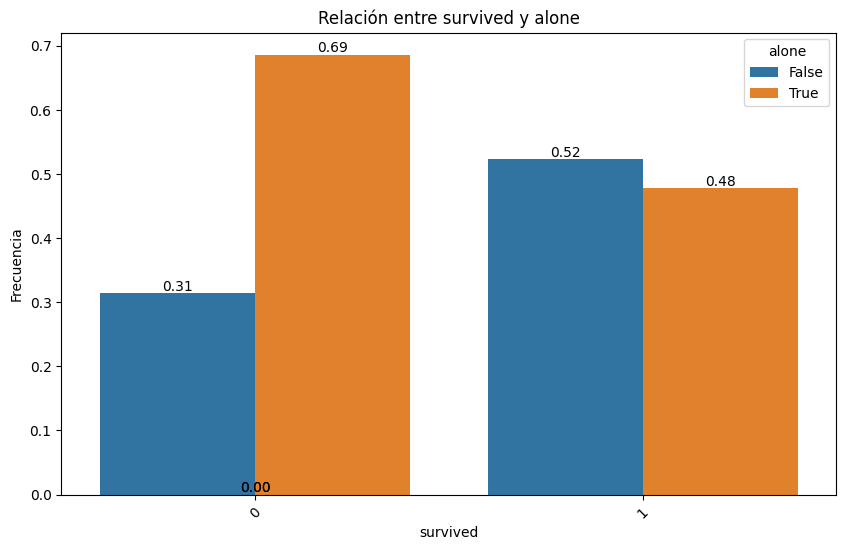

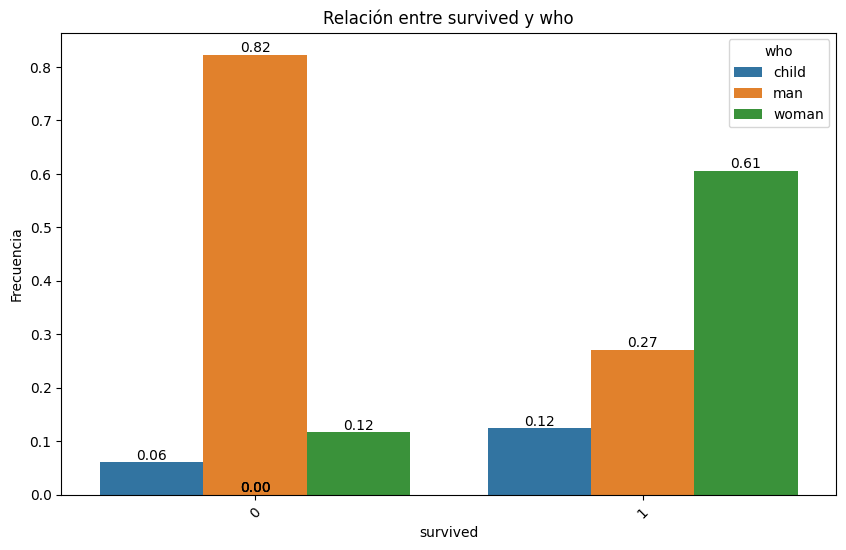

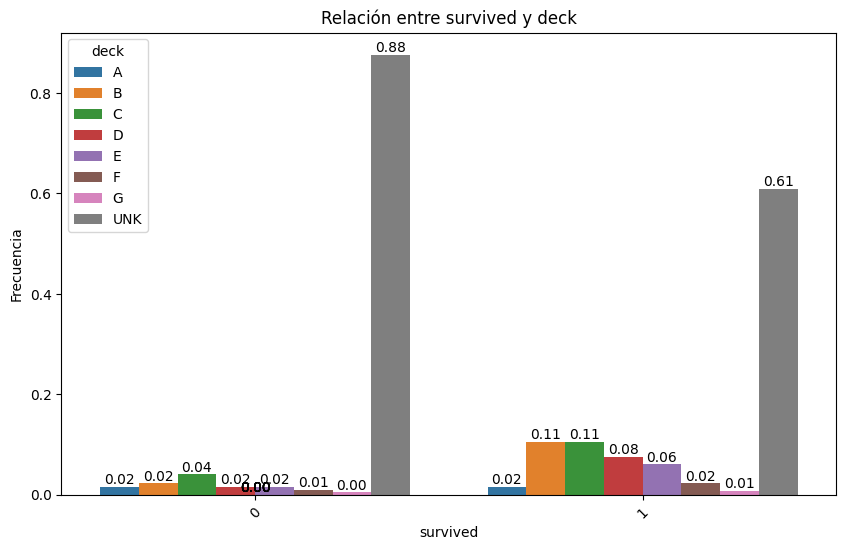

In [24]:
for feat in features_cat:
    bt.plot_categorical_relationship_fin(train_set, target, feat, show_values= True, relative_freq= True)

In [25]:
train_set["deck_informed"] = train_set.deck != "UNK" # marcamos dónde estaban los valores no nulos

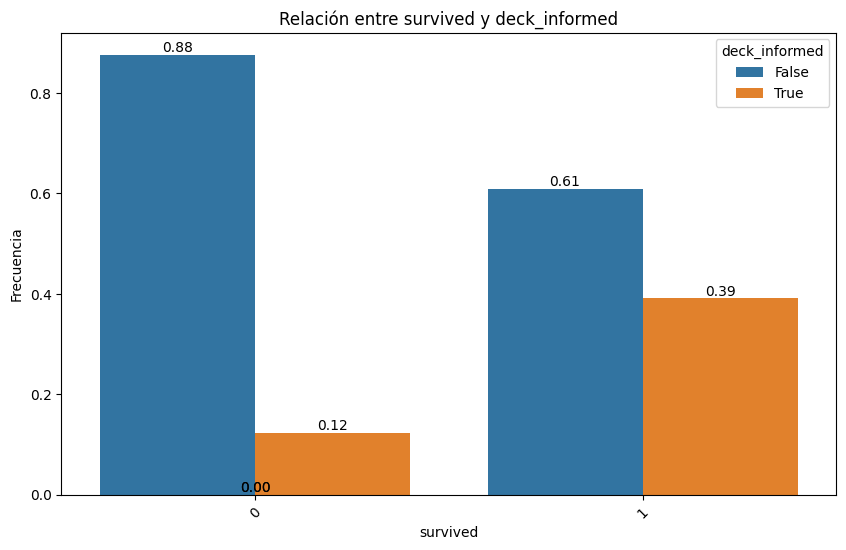

In [26]:
bt.plot_categorical_relationship_fin(train_set, target,"deck_informed", show_values= True, relative_freq= True)

Me quedo con "pclass","who","embarked","alone","deck" (lo probaré con "deck_informed") y por si acaso "fare" y "age" (sex y sibsp también)

In [27]:
features_cat.remove("deck")
features_cat.append("deck_informed")

In [28]:
features_num

['fare', 'age', 'sibsp']

In [29]:
features_cat

['pclass', 'sex', 'embarked', 'alone', 'who', 'deck_informed']

### Procesando categoricas

In [30]:
from sklearn.preprocessing import OrdinalEncoder

In [31]:
categories = [["male","female"],["S","C","Q"], ["child","woman","man"]]
encoder = OrdinalEncoder(categories= categories)
train_set[["sex","embarked","who"]] = encoder.fit_transform(train_set[["sex","embarked","who"]])
test_set[["sex","embarked","who"]] = encoder.transform(test_set[["sex","embarked","who"]])

In [32]:
train_set[["sex","embarked","who"]]

,sex,embarked,who
838,0.0,0.0,2.0
621,0.0,0.0,2.0
282,0.0,0.0,2.0
275,1.0,0.0,1.0
217,0.0,0.0,2.0
...,...,...,...
594,0.0,0.0,2.0
166,1.0,0.0,1.0
121,0.0,0.0,2.0
785,0.0,0.0,2.0


In [33]:
#train_set = pd.get_dummies(train_set, columns=["embarked","who","deck"], dtype = int)
#test_set  = pd.get_dummies(test_set, columns =["embarked","who","deck"], dtype = int)

### Procesando numéricas

array([[<Axes: title={'center': 'fare'}>,
        <Axes: title={'center': 'age'}>],
       [<Axes: title={'center': 'sibsp'}>, <Axes: >]], dtype=object)

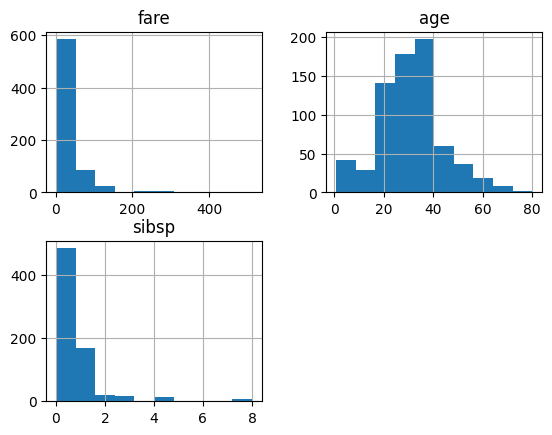

In [34]:
train_set[features_num].hist()

ValueError: supplied range of [-inf, 6.238967387173662] is not finite

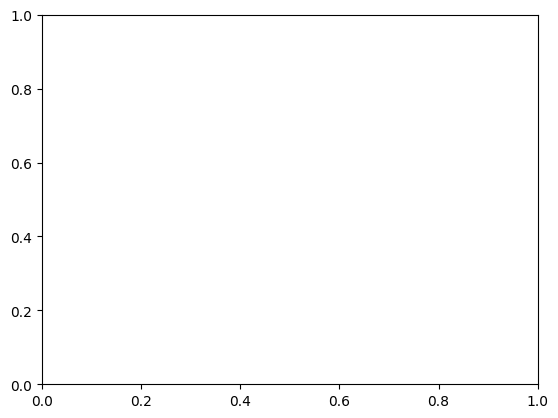

In [35]:
train_set["fare"].apply(np.log).hist()


Deberíamos tratar el fare no podemos hacer logaritmos, posibles opciones:
1. Hacer log(x+1)
2. Hacer sqrt(x) o cbrt(x)  (raiz cúbica)

<Axes: >

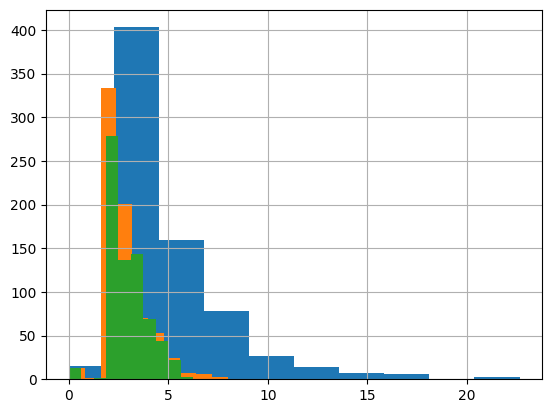

In [36]:
np.sqrt(train_set["fare"]).hist()
np.cbrt(train_set["fare"]).hist()
np.log(train_set["fare"]+1).hist() # en este caso es por el 0, log(0) es -inf pero raiz de 0 es 0


<Axes: >

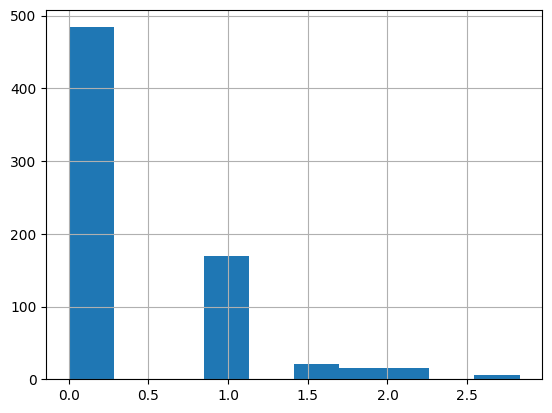

In [37]:
train_set["sibsp"].apply(np.sqrt).hist()

<Axes: >

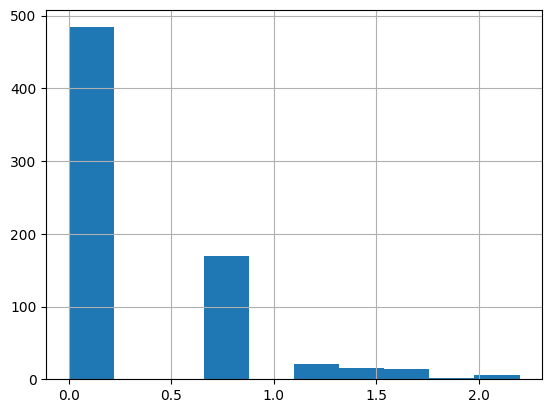

In [38]:
np.log(train_set["sibsp"]+1).hist()

In [39]:
train_set["fare"] = np.sqrt(train_set["fare"])
test_set["fare"] = np.sqrt(test_set["fare"])
train_set["sibsp"] = np.sqrt(train_set["sibsp"])
test_set["sibsp"] = np.sqrt(test_set["sibsp"])

In [40]:
train_set

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone,deck_informed
838,1,3,0.0,32.000000,0.000000,0,7.516369,0.0,Third,2.0,True,UNK,Southampton,yes,True,False
621,1,1,0.0,42.000000,1.000000,0,7.249428,0.0,First,2.0,True,D,Southampton,yes,False,True
282,0,3,0.0,16.000000,0.000000,0,3.082207,0.0,Third,2.0,True,UNK,Southampton,no,True,False
275,1,1,1.0,63.000000,1.000000,0,8.829400,0.0,First,1.0,False,D,Southampton,yes,False,True
217,0,2,0.0,42.000000,1.000000,0,5.196152,0.0,Second,2.0,True,UNK,Southampton,no,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
594,0,2,0.0,37.000000,1.000000,0,5.099020,0.0,Second,2.0,True,UNK,Southampton,no,False,False
166,1,1,1.0,32.008982,0.000000,1,7.416198,0.0,First,1.0,False,E,Southampton,yes,False,True
121,0,3,0.0,33.655689,0.000000,0,2.837252,0.0,Third,2.0,True,UNK,Southampton,no,True,False
785,0,3,0.0,25.000000,0.000000,0,2.692582,0.0,Third,2.0,True,UNK,Southampton,no,True,False


In [41]:
scaler = StandardScaler()


In [42]:
train_set[features_num] = scaler.fit_transform(train_set[features_num])


In [43]:
test_set[features_num] = scaler.transform(test_set[features_num])

In [44]:
train_set.describe()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,who
count,712.000000,712.000000,712.000000,7.120000e+02,7.120000e+02,712.000000,7.120000e+02,712.00000,712.000000
mean,0.373596,2.311798,0.342697,-1.908586e-16,1.596725e-16,0.356742,1.147646e-16,0.36236,1.532303
std,0.484098,0.840920,0.474945,1.000703e+00,1.000703e+00,0.736231,1.000703e+00,0.63701,0.646593
min,0.000000,1.000000,0.000000,-2.290427e+00,-6.337193e-01,0.000000,-1.619030e+00,0.00000,0.000000
25%,0.000000,2.000000,0.000000,-6.143837e-01,-6.337193e-01,0.000000,-6.780615e-01,0.00000,1.000000
50%,0.000000,3.000000,0.000000,9.100053e-02,-6.337193e-01,0.000000,-3.458961e-01,0.00000,2.000000
75%,1.000000,3.000000,1.000000,3.950514e-01,1.001958e+00,0.000000,2.318352e-01,1.00000,2.000000
max,1.000000,3.000000,1.000000,3.747138e+00,3.992675e+00,5.000000,5.960664e+00,2.00000,2.000000


In [45]:
test_set[features_num].describe()

,fare,age,sibsp
count,179.000000,179.000000,179.000000
mean,0.027382,-0.162056,-0.017497
std,0.930585,0.971355,1.007958
min,-1.619030,-2.315567,-0.633719
25%,-0.668918,-0.671522,-0.633719
50%,-0.345896,-0.138235,-0.633719
75%,0.331749,0.229568,1.001958
max,3.432136,2.604381,3.992675


Preparemos unos cuantos sets a ver cuál se comporta mejor

In [46]:
train_set

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone,deck_informed
838,1,3,0.0,0.090316,-0.633719,0,0.897981,0.0,Third,2.0,True,UNK,Southampton,yes,True,False
621,1,1,0.0,0.852154,1.001958,0,0.808591,0.0,First,2.0,True,D,Southampton,yes,False,True
282,0,3,0.0,-1.128624,-0.633719,0,-0.586889,0.0,Third,2.0,True,UNK,Southampton,no,True,False
275,1,1,1.0,2.452013,1.001958,0,1.337677,0.0,First,1.0,False,D,Southampton,yes,False,True
217,0,2,0.0,0.852154,1.001958,0,0.121009,0.0,Second,2.0,True,UNK,Southampton,no,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
594,0,2,0.0,0.471235,1.001958,0,0.088482,0.0,Second,2.0,True,UNK,Southampton,no,False,False
166,1,1,1.0,0.091001,-0.633719,1,0.864437,0.0,First,1.0,False,E,Southampton,yes,False,True
121,0,3,0.0,0.216453,-0.633719,0,-0.668918,0.0,Third,2.0,True,UNK,Southampton,no,True,False
785,0,3,0.0,-0.442970,-0.633719,0,-0.717363,0.0,Third,2.0,True,UNK,Southampton,no,True,False


In [47]:
#features_cat_set_1 = ["pclass"] + [col for col in train_set.columns if col.startswith("who_")]

In [48]:
#features_cat_set_1

In [49]:
#features_cat

In [50]:
#train_set = pd.get_dummies(train_set, columns = ["sex"], dtype = int)

In [51]:
train_set.head(1)

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone,deck_informed
838,1,3,0.0,0.090316,-0.633719,0,0.897981,0.0,Third,2.0,True,UNK,Southampton,yes,True,False


In [52]:
#features_cat_set_2 = features_cat_set_1 + ["alone","deck_informed","sex_female","sex_male","embarked_S","embarked_C","embarked_Q"]

In [53]:
#features_cat_set_2

In [54]:
features_set_cat_1 = ["pclass","who"]
features_set_cat_2 = features_cat

In [55]:
features_set_cat_1

['pclass', 'who']

In [56]:
features_set_cat_2

['pclass', 'sex', 'embarked', 'alone', 'who', 'deck_informed']

In [57]:
features_num

['fare', 'age', 'sibsp']

### Modelado

In [58]:
X_train = train_set[features_set_cat_1]
y_train = train_set[target]
X_test = test_set[features_set_cat_1]
y_test = test_set[target]

In [59]:
log_class = LogisticRegression(max_iter = 10000)

log_class.fit(X_train, y_train)


LogisticRegression(max_iter=10000)

In [60]:
def metrics_titanic(model,X, y_target):
    y_pred = model.predict(X)
    ConfusionMatrixDisplay.from_predictions(y_target, y_pred)
    print(classification_report(y_target, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.92      0.85       446
           1       0.82      0.56      0.67       266

    accuracy                           0.79       712
   macro avg       0.80      0.74      0.76       712
weighted avg       0.79      0.79      0.78       712



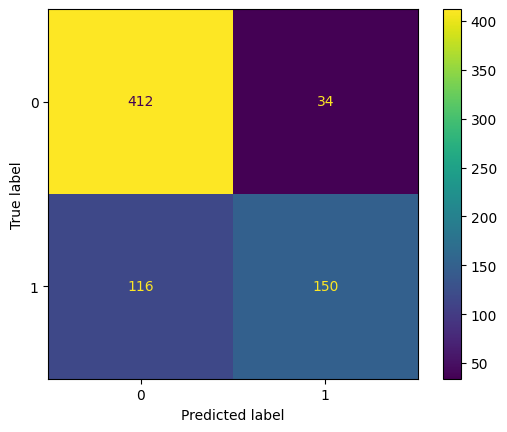

In [61]:
### train metrics
metrics_titanic(log_class, X_train,y_train)

              precision    recall  f1-score   support

           0       0.77      0.92      0.84       103
           1       0.86      0.63      0.73        76

    accuracy                           0.80       179
   macro avg       0.81      0.78      0.78       179
weighted avg       0.81      0.80      0.79       179



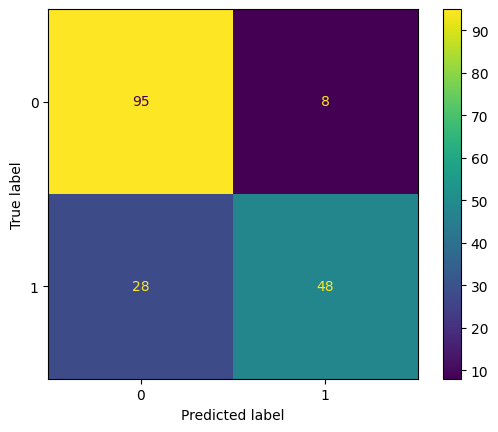

In [62]:
### test_metrics
metrics_titanic(log_class, X_test,y_test)


AUROC: 0.88


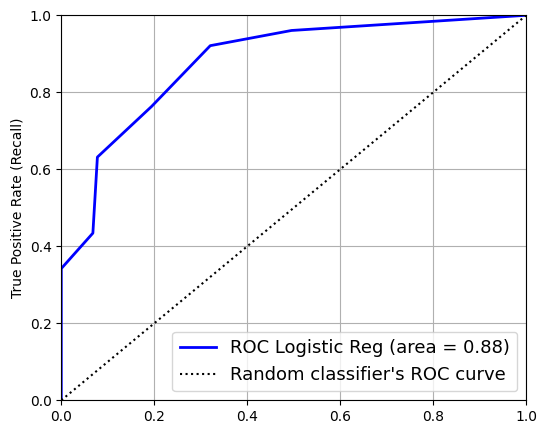

In [63]:
### Usando matplotlib
from sklearn.metrics import roc_curve, auc
scores = log_class.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, scores[:,1])
roc_auc = auc(fpr,tpr)
print("AUROC: %.2f" %(roc_auc))
plt.figure(figsize=(6, 5))  
plt.plot(fpr, tpr, linewidth=2, color= "blue", label=f"ROC Logistic Reg (area = {roc_auc:0.2f})")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower right", fontsize=13)

### Otro juego de features

In [64]:
train_set

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone,deck_informed
838,1,3,0.0,0.090316,-0.633719,0,0.897981,0.0,Third,2.0,True,UNK,Southampton,yes,True,False
621,1,1,0.0,0.852154,1.001958,0,0.808591,0.0,First,2.0,True,D,Southampton,yes,False,True
282,0,3,0.0,-1.128624,-0.633719,0,-0.586889,0.0,Third,2.0,True,UNK,Southampton,no,True,False
275,1,1,1.0,2.452013,1.001958,0,1.337677,0.0,First,1.0,False,D,Southampton,yes,False,True
217,0,2,0.0,0.852154,1.001958,0,0.121009,0.0,Second,2.0,True,UNK,Southampton,no,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
594,0,2,0.0,0.471235,1.001958,0,0.088482,0.0,Second,2.0,True,UNK,Southampton,no,False,False
166,1,1,1.0,0.091001,-0.633719,1,0.864437,0.0,First,1.0,False,E,Southampton,yes,False,True
121,0,3,0.0,0.216453,-0.633719,0,-0.668918,0.0,Third,2.0,True,UNK,Southampton,no,True,False
785,0,3,0.0,-0.442970,-0.633719,0,-0.717363,0.0,Third,2.0,True,UNK,Southampton,no,True,False


In [65]:
#features_cat_set_2

In [66]:
test_set.columns


Index(['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare',
       'embarked', 'class', 'who', 'adult_male', 'deck', 'embark_town',
       'alive', 'alone'],
      dtype='object')

In [67]:
train_set.columns

Index(['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare',
       'embarked', 'class', 'who', 'adult_male', 'deck', 'embark_town',
       'alive', 'alone', 'deck_informed'],
      dtype='object')

In [68]:
test_set.deck.value_counts(dropna = False)

deck
UNK    135
C       13
E        9
B        9
D        6
A        4
F        3
Name: count, dtype: int64

In [69]:
test_set["deck_informed"] = test_set["deck"] != "UNK"

In [70]:
X_train = train_set[features_set_cat_2]
y_train = train_set[target]
X_test = test_set[features_set_cat_2]
y_test = test_set[target]
log_class = LogisticRegression(max_iter = 10000)
log_class.fit(X_train, y_train)

LogisticRegression(max_iter=10000)

Lo siguiente es cómo completar el onehot encondig cuando se ha hecho con get_dummies de pandas y en test no había alguno de los valores:
(Hacerlo así no es la mejor forma, más adelante profundizaremos en el concepto)

In [ ]:
# Esto NO se hará así, es más fácil codificarlo de otra forma mejor, que es una línea, pero veremos ese concepto otro día

for col in X_train.columns:
    if col not in test_set:
        test_set[col] = 0
X_train = train_set[features_set_cat_2]
y_train = train_set[target]
X_test = test_set[features_set_cat_2]
y_test = test_set[target]
log_class = LogisticRegression(max_iter = 10000)
log_class.fit(X_train, y_train)

LogisticRegression(max_iter=10000)

              precision    recall  f1-score   support

           0       0.82      0.88      0.85       446
           1       0.77      0.67      0.72       266

    accuracy                           0.80       712
   macro avg       0.79      0.78      0.78       712
weighted avg       0.80      0.80      0.80       712



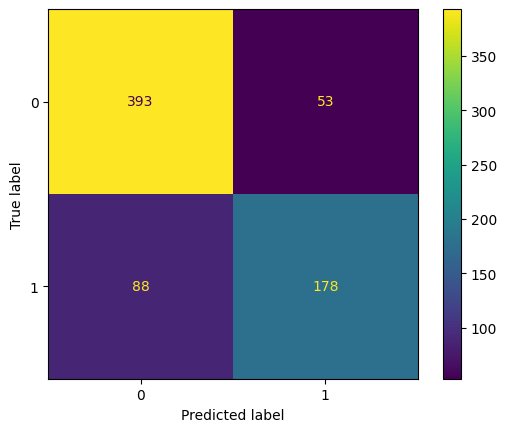

In [72]:
metrics_titanic(log_class, X_train,y_train)

              precision    recall  f1-score   support

           0       0.83      0.91      0.87       103
           1       0.86      0.75      0.80        76

    accuracy                           0.84       179
   macro avg       0.85      0.83      0.84       179
weighted avg       0.85      0.84      0.84       179



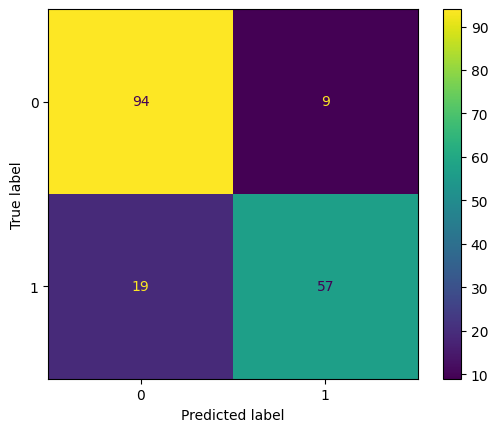

In [73]:
### test_metrics
metrics_titanic(log_class, X_test,y_test)

AUROC: 0.90


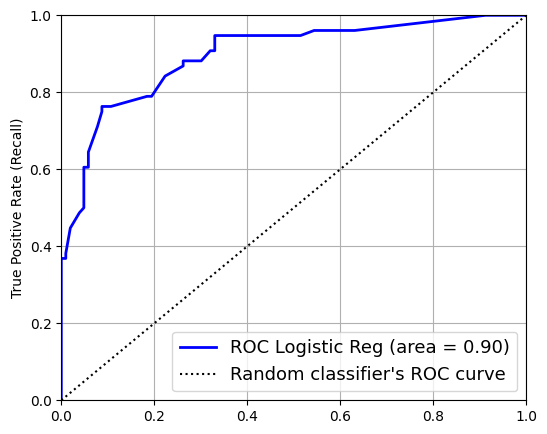

In [74]:
### Usando matplotlib
from sklearn.metrics import roc_curve, auc
scores = log_class.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, scores[:,1])
roc_auc = auc(fpr,tpr)
print("AUROC: %.2f" %(roc_auc))
plt.figure(figsize=(6, 5))  
plt.plot(fpr, tpr, linewidth=2, color= "blue", label=f"ROC Logistic Reg (area = {roc_auc:0.2f})")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower right", fontsize=13)

In [75]:
### Con numéricas

X_train = train_set[features_set_cat_2 + features_num]
y_train = train_set[target]
X_test = test_set[features_set_cat_2 + features_num]
y_test = test_set[target]
log_class = LogisticRegression(max_iter = 10000)
log_class.fit(X_train, y_train)

LogisticRegression(max_iter=10000)

              precision    recall  f1-score   support

           0       0.83      0.87      0.85       446
           1       0.76      0.69      0.72       266

    accuracy                           0.80       712
   macro avg       0.79      0.78      0.78       712
weighted avg       0.80      0.80      0.80       712



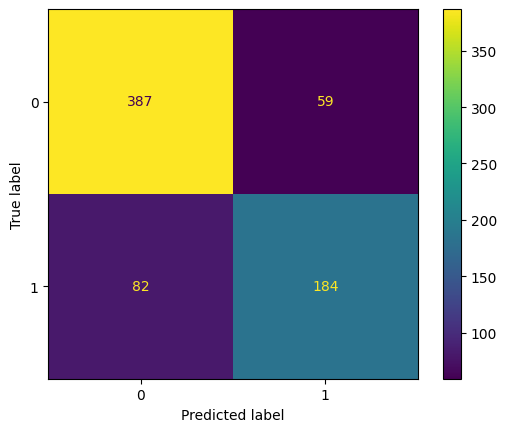

In [76]:
metrics_titanic(log_class, X_train, y_train)

              precision    recall  f1-score   support

           0       0.86      0.89      0.88       103
           1       0.85      0.80      0.82        76

    accuracy                           0.85       179
   macro avg       0.85      0.85      0.85       179
weighted avg       0.85      0.85      0.85       179



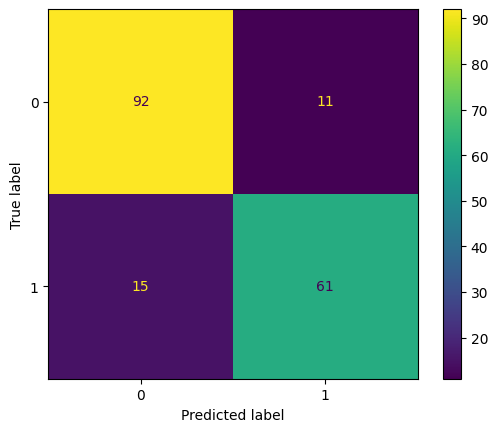

In [77]:
metrics_titanic(log_class, X_test, y_test)

AUROC: 0.91


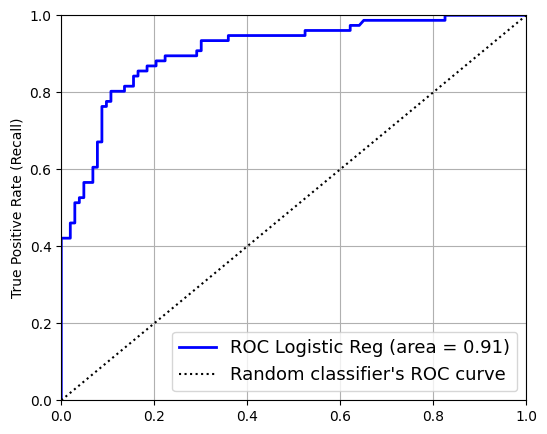

In [78]:
### Usando matplotlib
from sklearn.metrics import roc_curve, auc
scores = log_class.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, scores[:,1])
roc_auc = auc(fpr,tpr)
print("AUROC: %.2f" %(roc_auc))
plt.figure(figsize=(6, 5))  
plt.plot(fpr, tpr, linewidth=2, color= "blue", label=f"ROC Logistic Reg (area = {roc_auc:0.2f})")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower right", fontsize=13)

EXTRA: Halla la probabilidad de supervivencia de un hombre de entre 30 y 40 años, que embarcó en Southampton, [en segunda clase] viajaba solo y no pagó el billete. Incorrecto: Para ello recuerda que la probabilidad del suceso unión de sucesos indepentientes es la suma de las probabilidades de los sucesos por separado. Usaremos la media de probabilidades


In [79]:
features_set_cat_2 + features_num

['pclass',
 'sex',
 'embarked',
 'alone',
 'who',
 'deck_informed',
 'fare',
 'age',
 'sibsp']

In [80]:
data_base = {
    "pclass": 2,
    "embarked": 0,
    "alone": True,
    "fare": 0,
    "who":2,
    "deck_informed": 0,
    "sibsp": 0,
    "sex": 0
}
probs = []
for age in range(30,41):
    data = data_base.copy()
    data["age"] = age
    X_man = pd.DataFrame([data])
    X_man[features_num] = scaler.transform(X_man[features_num])
    print(X_man)
    prob_dead, prob_surv = log_class.predict_proba(X_man[features_set_cat_2 + features_num])[0] # primera fila (solo hay una)
    probs.append(prob_surv)
print("Prob media de sobrevivir:", np.mean(probs))

   pclass  embarked  alone     fare  who  deck_informed     sibsp  sex  \
0       2         0   True -1.61903    2              0 -0.633719    0   

        age  
0 -0.062051  
   pclass  embarked  alone     fare  who  deck_informed     sibsp  sex  \
0       2         0   True -1.61903    2              0 -0.633719    0   

        age  
0  0.014132  
   pclass  embarked  alone     fare  who  deck_informed     sibsp  sex  \
0       2         0   True -1.61903    2              0 -0.633719    0   

        age  
0  0.090316  
   pclass  embarked  alone     fare  who  deck_informed     sibsp  sex     age
0       2         0   True -1.61903    2              0 -0.633719    0  0.1665
   pclass  embarked  alone     fare  who  deck_informed     sibsp  sex  \
0       2         0   True -1.61903    2              0 -0.633719    0   

        age  
0  0.242684  
   pclass  embarked  alone     fare  who  deck_informed     sibsp  sex  \
0       2         0   True -1.61903    2              0 -0.6



EXTRA: Aprovecha todo el trabajo haciendo un único cambio en el target, ahora será la clase del viajero. Cambia el target quitándolo de X_train, X_test y añade a estos el target anterior. El resto no deberías cambiarlo. Entrena y evalua el modelo sólo con el classification_report.  

In [81]:
target = "survived"

In [82]:
new_features = features_set_cat_2 + features_num + [target]
new_target = "pclass"
new_features.remove(new_target)
print(new_features)


['sex', 'embarked', 'alone', 'who', 'deck_informed', 'fare', 'age', 'sibsp', 'survived']


In [83]:
X_train = train_set[new_features]
y_train = train_set[new_target]
X_test = test_set[new_features]
y_test = test_set[new_target]

In [84]:
X_train

,sex,embarked,alone,who,deck_informed,fare,age,sibsp,survived
838,0.0,0.0,True,2.0,False,0.897981,0.090316,-0.633719,1
621,0.0,0.0,False,2.0,True,0.808591,0.852154,1.001958,1
282,0.0,0.0,True,2.0,False,-0.586889,-1.128624,-0.633719,0
275,1.0,0.0,False,1.0,True,1.337677,2.452013,1.001958,1
217,0.0,0.0,False,2.0,False,0.121009,0.852154,1.001958,0
...,...,...,...,...,...,...,...,...,...
594,0.0,0.0,False,2.0,False,0.088482,0.471235,1.001958,0
166,1.0,0.0,False,1.0,True,0.864437,0.091001,-0.633719,1
121,0.0,0.0,True,2.0,False,-0.668918,0.216453,-0.633719,0
785,0.0,0.0,True,2.0,False,-0.717363,-0.442970,-0.633719,0


In [85]:
log_class.fit(X_train,y_train)

LogisticRegression(max_iter=10000)

              precision    recall  f1-score   support

           1       0.90      0.89      0.89       175
           2       0.68      0.31      0.42       140
           3       0.79      0.94      0.86       397

    accuracy                           0.80       712
   macro avg       0.79      0.71      0.73       712
weighted avg       0.79      0.80      0.78       712



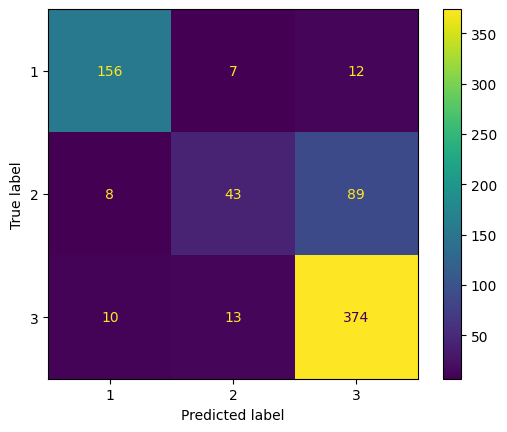

In [86]:
metrics_titanic(log_class,X_train, y_train)

              precision    recall  f1-score   support

           1       0.89      1.00      0.94        41
           2       0.72      0.41      0.52        44
           3       0.81      0.93      0.86        94

    accuracy                           0.82       179
   macro avg       0.81      0.78      0.78       179
weighted avg       0.80      0.82      0.80       179



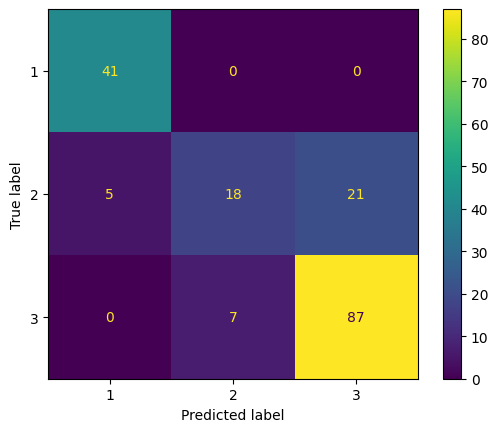

In [87]:
metrics_titanic(log_class,X_test, y_test)